In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde, mode

In [3]:
base_path = Path("result/20240307_steady_temperature")

csv_files = list(base_path.glob("*/s2/result.csv"))
sorted_csv_files = sorted(
    csv_files, key=lambda x: x.parent.parent.name.split("_")[:2]
)

In [4]:
# 마지막 600개의 데이터를 저장할 빈 리스트 생성
data_list = []

# 각 파일에서 마지막 600개의 데이터 읽어오기
for file_path in sorted_csv_files:
    df = pd.read_csv(file_path)
    last_600_rows = df.iloc[:]
    data_list.append(last_600_rows)

# 모든 데이터를 하나의 데이터프레임으로 합치기
df2 = pd.concat(data_list, ignore_index=True)

In [5]:
df2

,Timestamp,Ambient Temperature,Power,CPU Temperature,TPU Temperature
0,2024-03-11 15:52:13.500,23.5,4.082565,56.0,53.55
1,2024-03-11 15:52:13.600,23.5,3.593033,56.0,53.05
2,2024-03-11 15:52:13.700,23.5,3.210161,56.0,53.55
3,2024-03-11 15:52:13.800,23.5,3.210759,56.0,53.30
4,2024-03-11 15:52:13.900,23.5,3.145108,56.0,53.55
...,...,...,...,...,...
90054,2024-03-12 18:45:43.600,20.9,3.133613,55.0,53.30
90055,2024-03-12 18:45:43.700,20.8,3.529569,55.0,53.05
90056,2024-03-12 18:45:43.800,20.8,3.133589,55.0,53.30
90057,2024-03-12 18:45:43.900,20.8,4.203487,55.0,53.30


In [8]:
def linear_func(T, a, b):
    return a * T + b


# TPU Temperature 값을 고유한 값으로 가져와서 오름차순으로 정렬
unique_temps = np.sort(df2["TPU Temperature"].unique())
unique_temps = unique_temps[1:]


# 각 TPU Temperature 값에 대한 Power 값 가져오기 (이상치 제외)
power_data = [
    df2[
        (df2["TPU Temperature"] == temp)
        & (df2["Power"] < df2["Power"].quantile(0.99))
    ]["Power"]
    for temp in unique_temps
]

# 각 TPU Temperature에 대한 Power의 90번째 백분위수 구하기
power_percentiles = [np.percentile(data, 90) for data in power_data]

# 90번째 백분위수를 사용하여 회귀선 피팅
popt, pcov = curve_fit(linear_func, unique_temps, power_percentiles)
a, b = popt

print(f"Estimated coefficients: a = {a:.6f}, b = {b:.6f}")

Estimated coefficients: a = 0.006780, b = 2.863760


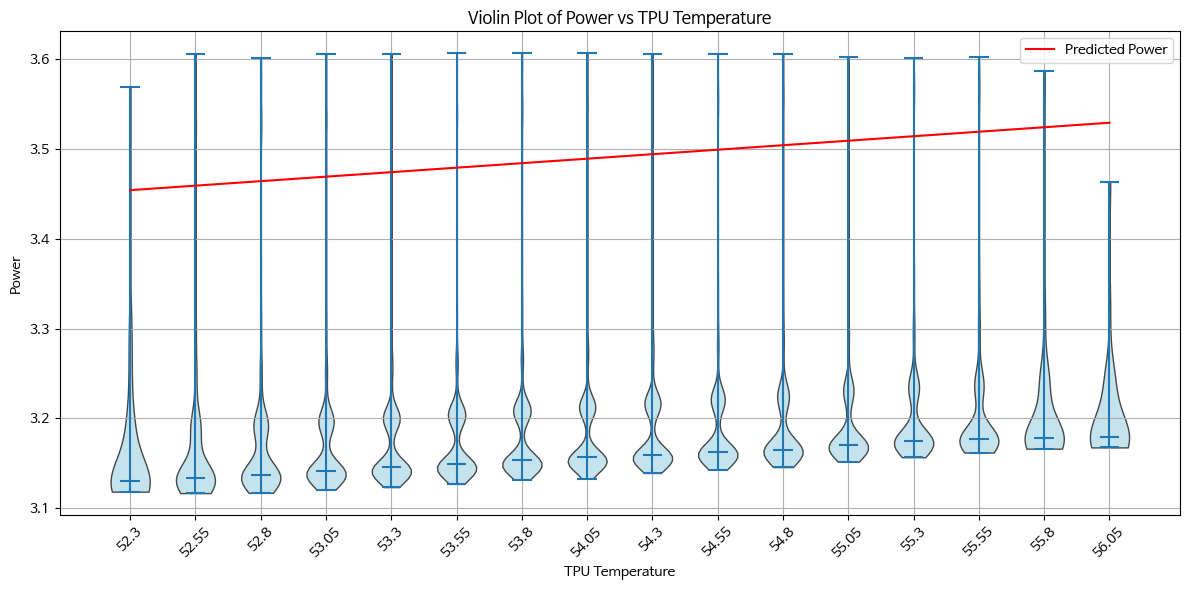

In [9]:
a, b = 0.02, 2.408

# 바이올린 플롯 그리기
fig, ax = plt.subplots(figsize=(12, 6))
positions = range(len(unique_temps))
violin_parts = ax.violinplot(
    power_data, positions=positions, widths=0.6, showmedians=True
)

# 바이올린 플롯의 색상 설정
for pc in violin_parts["bodies"]:
    pc.set_facecolor("lightblue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.7)

# 회귀선 그리기
T_pred = np.linspace(unique_temps.min(), unique_temps.max(), 100)
Power_pred = linear_func(T_pred, a, b)
ax.plot(
    np.interp(T_pred, unique_temps, positions),
    Power_pred,
    color="r",
    label="Predicted Power",
)

# 그래프 설정
ax.set_xlabel("TPU Temperature")
ax.set_ylabel("Power")
ax.set_title("Violin Plot of Power vs TPU Temperature")
ax.set_xticks(positions)
ax.set_xticklabels(unique_temps, rotation=45)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()